# Fine-tune LayoutXLM for semantic entity recognition (also known as NER)

In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the French part of the multilingual [XFUND](https://github.com/doc-analysis/XFUND) dataset. The goal for the model is to label words appearing in scanned documents appropriately. We'll start from the weights of [microsoft/layoutxlm-base](https://huggingface.co/microsoft/layoutxlm-base), which has been pre-trained on millions of multilingual documents, in 7 languages (Chinese, Japanese, Spanish, French, Italian, German, Portuguese).

This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning. LayoutXLM is equivalent to LayoutLMv2, the only difference being the pre-trained weights.

* LayoutLMv2 paper: https://arxiv.org/abs/2012.14740
* LayoutXLM paper: https://arxiv.org/abs/2104.08836
* Original repo: https://github.com/microsoft/unilm

## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2/LayoutXLM model)
* Datasets (for data preprocessing)
* Sentencepiece (used for tokenization)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [1]:
!git clone https://github.com/RomanChaganov/ner-re-project.git

Cloning into 'ner-re-project'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 81 (delta 19), reused 47 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 459.49 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [1]:
%cd ner-re-project

/content/ner-re-project


In [26]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [65]:
!rm -r resources/data/
!unrar x data.rar resources/data/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data.rar

Creating    resources/data                                            OK
Creating    resources/data/train                                      OK
Extracting  resources/data/train/file1.ann                            OK 
Extracting  resources/data/train/file1.txt                            OK 
Extracting  resources/data/train/file100.ann                          OK 
Extracting  resources/data/train/file100.txt                          OK 
Extracting  resources/data/train/file100_1.png                        OK 
Extracting  resources/data/train/file101.ann                          OK 
Extracting  resources/data/train/file101.txt                          OK 
Extracting  resources/data/train/file101_1.png                        OK 
Extracting  resources/data/train/file102.ann                          OK 
Extracting  resources/data/train/file102.txt                          OK 
Extracting  

In [1]:
!python scripts/mask_texts.py
# !python scripts/mask_texts.py --train-dir resources/data/test resources/data/train resources/data/test

100%|████████████████████████████████████████| 130/130 [00:00<00:00, 606.47it/s]


In [2]:
!mv resources/data/train/masked_texts.jsonl resources/data/train/masked_texts.json

In [3]:
!python mlm.py --device cuda --batch-size 5 --epochs 10

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
training:   0%|                                          | 0/22 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLargeIndex: block: [57,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1553: indexSelectLarge

In [4]:
!python -m scripts.tokenize_texts
!python -m scripts.tokenize_texts --dir resources/data/test --label2id resources/data/train/label2id.json --retag2id resources/data/train/retag2id.json

100%|████████████████████████████████████████| 130/130 [00:00<00:00, 269.29it/s]
0
100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 286.55it/s]
0


In [2]:
# !/home/mpirtgod/rep/tf/bin/pip install -v transformers datasets seqeval sentencepiece datasets focal_loss_torch
!pip install transformers datasets seqeval sentencepiece

In [22]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# !/home/mpirtgod/rep/tf/bin/pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2ofvobjx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2ofvobjx
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [28]:
!pip install -q torchvision==0.11+cu12 -f https://download.pytorch.org/whl/torch_stable.html

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.11+cu12 (from versions: 0.1.6, 0.2.0, 0.12.0, 0.12.0+cpu, 0.12.0+cu102, 0.12.0+cu113, 0.12.0+cu115, 0.12.0+rocm4.3.1, 0.12.0+rocm4.5.2, 0.13.0, 0.13.0+cpu, 0.13.0+cu102, 0.13.0+cu113, 0.13.0+cu116, 0.13.0+rocm5.0, 0.13.0+rocm5.1.1, 0.13.1, 0.13.1+cpu, 0.13.1+cu102, 0.13.1+cu113, 0.13.1+cu116, 0.13.1+rocm5.0, 0.13.1+rocm5.1.1, 0.14.0, 0.14.0+cpu, 0.14.0+cu116, 0.14.0+cu117, 0.14.0+rocm5.1.1, 0.14.0+rocm5.2, 0.14.1, 0.14.1+cpu, 0.14.1+cu116, 0.14.1+cu117, 0.14.1+rocm5.1.1, 0.14.1+rocm5.2, 0.15.0+cpu, 0.15.0+cu117, 0.15.0+cu118, 0.15.0+rocm5.3, 0.15.0+rocm5.4.2, 0.15.1, 0.15.1+cpu, 0.15.1+cu117, 0.15.1+cu118, 0.15.1+rocm5.3, 0.15.1+rocm5.4.2, 0.15.2, 0.15.2+cpu, 0.15.2+cu117, 0.15.2+cu118, 0.15.2+rocm5.3, 0.15.2+rocm5.4.2, 0.16.0, 0.16.0+cpu, 0.16.0+cu118, 0.16.0+cu121, 0.16.0+rocm5.5, 

In [ ]:
!pip install -q torch==1.10.0+cu12

In [4]:
!huggingface-cli login

/bin/bash: line 1: huggingface-cli: command not found


To be able to share your model with the community on the HuggingFace hub, we'll log in below.


## Prepare the data

Let's load the XFUN dataset from the HuggingFace hub.

Note: I just took this from Microsoft's [repo](https://github.com/microsoft/unilm/blob/master/layoutlmft/layoutlmft/data/datasets/xfun.py) and pushed it to the hub. I also added an "original_image" key.

In [5]:
from datasets import load_dataset

dataset = load_dataset("json", data_files={"train": "resources/data/train/labeled_texts.jsonl", "test": "resources/data/test/labeled_texts.jsonl"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

As we can see, it contains a training and test split.

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'text_labels', 'labels', 'bbox', 'id', 'original_image'],
        num_rows: 182
    })
    test: Dataset({
        features: ['input_ids', 'text_labels', 'labels', 'bbox', 'id', 'original_image'],
        num_rows: 50
    })
})



This dataset is already in the format that the model expects, hence data preparation will be trivial. Normally, one can leverage [LayoutXLMProcessor](https://huggingface.co/docs/transformers/model_doc/layoutxlm#transformers.LayoutXLMProcessor) for preparing data for the model (which will turn word-level words, boxes and NER tags into token-level input_ids, bbox, labels etc).

However, as the Microsoft authors already prepared the data for us, the only thing we'll need to write is a [data collator](https://huggingface.co/docs/transformers/main_classes/data_collator), which PyTorch uses to batch the examples together.

Let's first create id2label and label2id mappings, useful when performing inference after training.

In [7]:
dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'text_labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='int64', id=None),
 'original_image': Value(dtype='string', id=None)}

In [8]:
labels = dataset['train'].features['labels']
print(labels)

Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)


In [9]:
import json
with open('resources/data/train/label2id.json', 'r', encoding='utf-8') as f:
    label2id = json.load(f)
label2id

{'B-VAL': 0,
 'O': 1,
 'B-KEY': 2,
 'I-VAL': 3,
 'B-HDR': 4,
 'I-KEY': 5,
 'I-HDR': 6}

In [10]:
id2label = {}
for key, value in label2id.items():
    id2label[value] = key
id2label

{0: 'B-VAL',
 1: 'O',
 2: 'B-KEY',
 3: 'I-VAL',
 4: 'B-HDR',
 5: 'I-KEY',
 6: 'I-HDR'}

## Define Data Collator

Below, we define this data collator. For that, we'll use `LayoutLMv2FeatureExtractor` for preparing the image inputs, and `LayoutXLMTokenizer` to pad the text inputs.

In [11]:
from transformers import LayoutLMv2FeatureExtractor, LayoutXLMTokenizer

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")

/home/mpirtgod/rep/tf/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [12]:
from transformers import PreTrainedTokenizerBase
from transformers.file_utils import PaddingStrategy
from torch.utils.data import DataLoader
from dataclasses import dataclass
import torch
from PIL import Image

from typing import Optional, Union

@dataclass
class DataCollatorForTokenClassification:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def normalize_bbox(self, bbox, width, height):
      return [
          int(1000 * (bbox[0] / width)),
          int(1000 * (bbox[1] / height)),
          int(1000 * (bbox[2] / width)),
          int(1000 * (bbox[3] / height)),
    ]

    def __call__(self, features):
    # Загружаем изображения
      images = [Image.open(feature["original_image"]).convert("RGB") for feature in features]
      image_tensors = self.feature_extractor(images, return_tensors="pt").pixel_values

      max_length = self.max_length  # Ограничение на длину

      for i, feature in enumerate(features):

          width, height = images[i].width, images[i].height

          feature["bbox"] = [self.normalize_bbox(x, width, height) for x in feature["bbox"]]
          # Обрезаем или дополняем `input_ids`
          # feature["input_ids"] = feature["input_ids"][:max_length]
          # while len(feature["input_ids"]) < max_length:
          #     feature["input_ids"].append(0)  # Padding токен

          # # Обрезаем или дополняем `bboxes`
          # feature["bbox"] = feature["bbox"][:max_length]
          # while len(feature["bbox"]) < max_length:
          #     feature["bbox"].append([0, 0, 0, 0])

          # # Преобразуем `labels` в числовые значения
          # feature["labels"] = [label2id[label] for label in feature["labels"] if label in label2id]
          # feature["labels"] = feature["labels"][:max_length]
          # while len(feature["labels"]) < max_length:
          #     feature["labels"].append(0)

          del feature["original_image"]
          del feature["text_labels"]
          del feature["id"]

          # 🔹 Проверяем корректность длины перед `pad()`
          assert len(feature["input_ids"]) == max_length, f"Ошибка: input_ids имеет длину {len(feature['input_ids'])}, ожидается {max_length}"
          assert len(feature["bbox"]) == max_length, f"Ошибка: bboxes имеет длину {len(feature['bboxes'])}, ожидается {max_length}"
          assert len(feature["labels"]) == max_length, f"Ошибка: labels имеет длину {len(feature['labels'])}, ожидается {max_length}"

      batch = self.tokenizer.pad(
          features,
          padding="max_length",
          max_length=self.max_length,
          return_tensors="pt"
      )

      batch["image"] = image_tensors

      return batch


data_collator = DataCollatorForTokenClassification(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)

train_dataset = dataset['train']
test_dataset = dataset['test']

## Create PyTorch DataLoader (for verification of collate function)

Next, we could create PyTorch DataLoaders and train the model in native PyTorch.

However, we'll use the HuggingFace Trainer in this notebook, as you can see further. We'll just need to provide our collate function defined above, and it will create dataloaders behind the scenes.

Below, we just create a PyTorch DataLoader to verify our collate function.

In [13]:
dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=data_collator)

Let's verify a batch:

In [14]:
batch = next(iter(dataloader))

for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 512])
labels torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
attention_mask torch.Size([4, 512])
image torch.Size([4, 3, 224, 224])


In [15]:
batch['input_ids'][0]

tensor([ 13072,    222,    135,    677,   1891,     20,  32622,    751,    438,
          1438,   9016,    248,    361,    183,   1438,      6,      5,   4880,
             6,      5,    387,   2357,  19832,   6417,  27183,    438,   2451,
           183,    292,  86023,     44,  27874,  24038,  18459,    245,     44,
           811,  62905,    547,      6,      4, 218419,    135,  42905,   1857,
         95076,    743,     44,    447,   1941, 209467,  14909,   8269,  34911,
            44, 109810,  90458,   8979,     15,  15886,   1388, 177628,   2097,
        165022,     15,    135,    677,   1891,   1388, 114110,    438,    201,
          5955,    183,   1105,      6,      5,   4648,      6,      5,    505,
        191273,  80319,    380,  25440,     29,  90938,   2429,  12919,  21069,
         97945,   3526,  28403,   7227,  15229,    103,   9798,  94384,  18372,
           417,   2744,      6,      5,   2390,      6,      5, 217310,  16041,
        217310,  94384,  18372,  80622, 

In [16]:
batch['bbox']

tensor([[[292,  37, 326,  47],
         [292,  37, 326,  47],
         [333,  39, 482,  50],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[261,  37, 295,  47],
         [261,  37, 295,  47],
         [302,  39, 451,  50],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[510, 624, 859, 644],
         [510, 624, 859, 644],
         [510, 624, 859, 644],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[306,  37, 340,  47],
         [306,  37, 340,  47],
         [347,  39, 496,  50],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]]])

In [17]:
for id, label, bbox in zip(batch['input_ids'][0], batch['labels'][0], batch['bbox'][0]):
  print(tokenizer.decode([id.item()]), id2label[label.item()], bbox)

Ак B-HDR tensor([292,  37, 326,  47])
т I-HDR tensor([292,  37, 326,  47])
с B-HDR tensor([333,  39, 482,  50])
да I-HDR tensor([333,  39, 482,  50])
чи I-HDR tensor([333,  39, 482,  50])
- I-HDR tensor([333,  39, 482,  50])
прием I-HDR tensor([333,  39, 482,  50])
ки I-HDR tensor([333,  39, 482,  50])
No B-HDR tensor([490,  37, 572,  47])
27 I-HDR tensor([490,  37, 572,  47])
06 I-HDR tensor([490,  37, 572,  47])
/ I-HDR tensor([490,  37, 572,  47])
7 I-HDR tensor([490,  37, 572,  47])
от O tensor([579,  39, 600,  47])
27 O tensor([607,  37, 707,  47])
 O tensor([607,  37, 707,  47])
. O tensor([607,  37, 707,  47])
06 O tensor([607,  37, 707,  47])
 O tensor([607,  37, 707,  47])
. O tensor([607,  37, 707,  47])
20 O tensor([607,  37, 707,  47])
24 O tensor([607,  37, 707,  47])
Ис O tensor([416,  60, 508,  70])
прав O tensor([416,  60, 508,  70])
ление O tensor([416,  60, 508,  70])
No O tensor([506,  56, 546,  68])
— O tensor([506,  56, 546,  68])
от O tensor([549,  62, 564,  67])


It's always important to also verify that the resized image and normalized bounding boxes are set up properly.

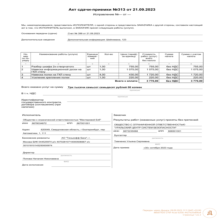

In [18]:
import numpy as np
from PIL import Image

image_to_verify = batch['image'][3].numpy()
image_to_verify = np.moveaxis(image_to_verify, source=0, destination=-1)
image_to_verify = Image.fromarray(image_to_verify)
image_to_verify

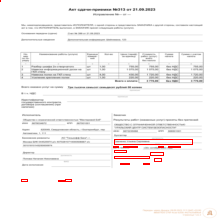

In [19]:
from PIL import ImageDraw

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

draw = ImageDraw.Draw(image_to_verify)
for bbox in batch['bbox'][2]:
    draw.rectangle(unnormalize_box(bbox, width=224, height=224), outline='red', width=1)

image_to_verify

## Define the model

We first define the model. Here we instantiate the weights of the base Transformer with the pre-trained ones, and we add a randomly initialized head on top (a token classifier head) which we'll fine-tune together with the base model on our labeled dataset.


In [20]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutxlm-base',
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutxlm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define compute_metrics

We'll fine-tune the model using HuggingFace's [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer).

We'll first define a `compute_metrics` function, which we'll use when evaluating the model.

In [21]:
from evaluate import load
import numpy as np

# Metrics
metric = load("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [22]:
import transformers
print(transformers.__version__)

4.51.3


## Instantiate Trainer

We initialize a `Trainer` by passing our model as well as `TrainingArguments`, which define all the training hyperparameters. See the [docs](https://huggingface.co/transformers/main_classes/trainer.html) for all possible arguments.

In [23]:
dataset = train_dataset.train_test_split(test_size=0.1)
train_data = dataset["train"]
val_data = dataset["test"]

In [27]:
!pip install -U transformers

In [29]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir="layoutxlm-finetuned-docs-ru", # name of directory to store the checkpoints
    overwrite_output_dir=True,
    max_steps=1000, # we train for a maximum of 1,000 batches
    warmup_ratio=0.1, # we warmup a bit
    # fp16=True, # we use mixed precision (less memory consumption)
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    remove_unused_columns=False,
    eval_steps=50,                # частота валидации (например, каждые 50 шагов)
    # push_to_hub=True,
    # no_cuda=True#\ we'd like to push our model to the hub during training
)

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_8435/499294831.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train the model

Let's train the model! By default, the Trainer saves checkpoints every 500 steps.

In [30]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
trainer.train()

To compute metrics on the test set, we can run `trainer.predict()`. We get predictions, labels, and metrics back.

In [ ]:
import time

start_time = time.time()
predictions, labels, metrics = trainer.predict(test_dataset)
end_time = time.time()
print(f"Время инференса: {end_time - start_time:.2f} секунд")

In [ ]:
print(metrics)

The numbers I got where:

* run 1: `{'test_loss': 0.8593608140945435, 'test_ANSWER_precision': 0.7833850931677019, 'test_ANSWER_recall': 0.7858255451713395, 'test_ANSWER_f1': 0.7846034214618973, 'test_ANSWER_number': 1284, 'test_HEADER_precision': 0.5125, 'test_HEADER_recall': 0.6212121212121212, 'test_HEADER_f1': 0.5616438356164383, 'test_HEADER_number': 66, 'test_QUESTION_precision': 0.6685348278622898, 'test_QUESTION_recall': 0.813047711781889, 'test_QUESTION_f1': 0.733743409490334, 'test_QUESTION_number': 1027, 'test_overall_precision': 0.7202904088651128, 'test_overall_recall': 0.7930164072360117, 'test_overall_f1': 0.7549058870644774, 'test_overall_accuracy': 0.7834219255825107, 'test_runtime': 17.9311, 'test_samples_per_second': 3.96, 'test_steps_per_second': 2.008}`

* run 2: `{'test_loss': 0.8635098338127136, 'test_ANSWER_precision': 0.7651109410864575, 'test_ANSWER_recall': 0.778816199376947, 'test_ANSWER_f1': 0.7719027402547279, 'test_ANSWER_number': 1284, 'test_HEADER_precision': 0.38571428571428573, 'test_HEADER_recall': 0.4090909090909091, 'test_HEADER_f1': 0.3970588235294118, 'test_HEADER_number': 66, 'test_QUESTION_precision': 0.6751435602953241, 'test_QUESTION_recall': 0.801363193768257, 'test_QUESTION_f1': 0.7328584149599289, 'test_QUESTION_number': 1027, 'test_overall_precision': 0.7126348228043143, 'test_overall_recall': 0.7782919646613379, 'test_overall_f1': 0.7440176955560024, 'test_overall_accuracy': 0.7862995084129332, 'test_runtime': 19.5074, 'test_samples_per_second': 3.64, 'test_steps_per_second': 1.845}`


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_training_history(trainer):
    logs = trainer.state.log_history

    steps = []
    losses = []
    f1_scores = []

    for entry in logs:
        if "loss" in entry:
            steps.append(entry["step"])
            losses.append(entry["loss"])
        if "eval_f1" in entry:
            f1_scores.append((entry["step"], entry["eval_f1"]))

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))

    ax1.set_title("Training Loss")
    ax1.plot(steps, losses, label="loss")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")
    ax1.legend()

    if f1_scores:
        f1_x, f1_y = zip(*f1_scores)
        ax2.set_title("F1 Score")
        ax2.plot(f1_x, f1_y, color='green', label="f1")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("F1 Score")
        ax2.legend()

    plt.tight_layout()
    plt.show()

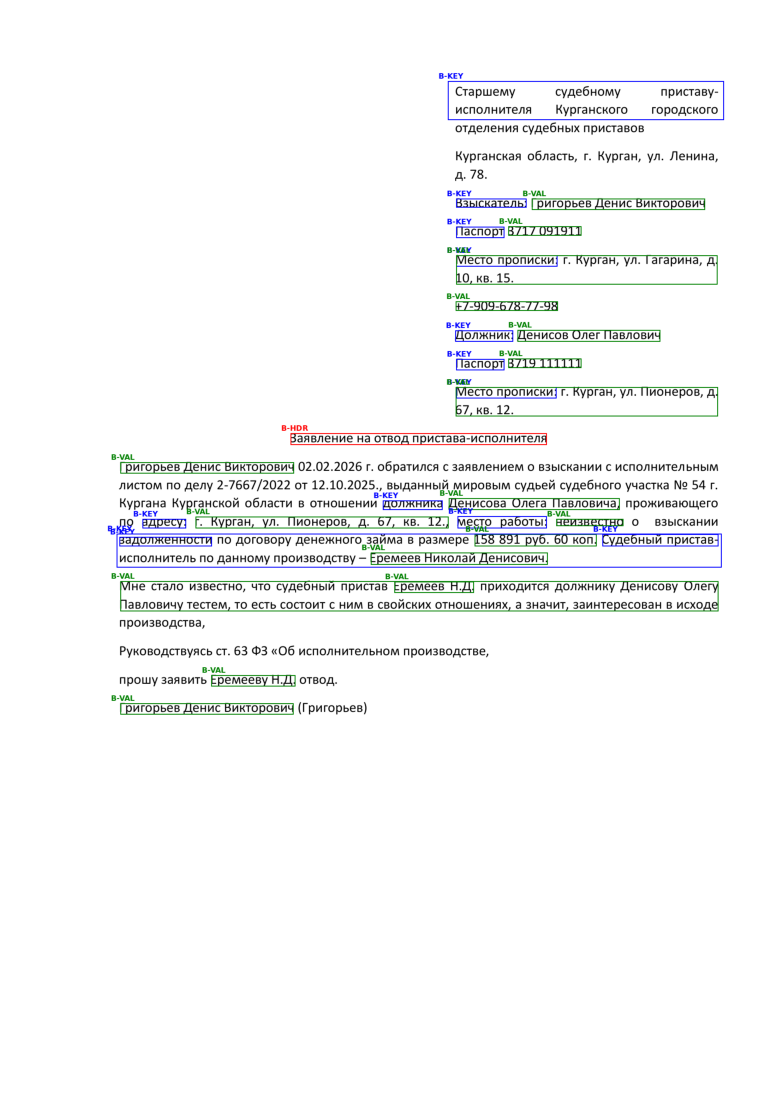

In [49]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch

im_num = 3

# Подгрузи картинку
image_path = test_dataset[im_num]["original_image"]
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

# Достаём данные
bboxes = test_dataset[im_num]["bbox"]
labels = test_dataset[im_num]["labels"]

# Цвета по классам
colors = {
    "B-KEY": "blue",
    "I-KEY": "blue",
    "B-VAL": "green",
    "I-VAL": "green",
    "B-HDR": "red",
    "I-HDR": "red", 
    "O": "gray"
}

# Шрифт (может не быть в Colab — можно закомментить)
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=16)
except:
    font = None

# Рисуем
for bbox, label_id in zip(bboxes, labels):
    label = id2label.get(label_id, "O")
    if label.startswith("B-"):  # Показываем только метки
        color = colors[label]
        draw.rectangle(bbox, outline=color, width=2)
        draw.text((bbox[0]-20, bbox[1]-20), label, fill=color, font=font)

# Покажем картинку
plt.figure(figsize=(10, 14))
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
!python3 -m scripts.prepare_data_for_re --num-labels 5

In [53]:
from transformers import AutoModel

model = AutoModel.from_pretrained("microsoft/layoutlmv2-base-uncased")

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

LayoutLMv2Config {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "convert_sync_batchnorm": true,
  "coordinate_size": 128,
  "detectron2_config_args": {
    "MODEL.ANCHOR_GENERATOR.SIZES": [
      [
        32
      ],
      [
        64
      ],
      [
        128
      ],
      [
        256
      ],
      [
        512
      ]
    ],
    "MODEL.BACKBONE.NAME": "build_resnet_fpn_backbone",
    "MODEL.FPN.IN_FEATURES": [
      "res2",
      "res3",
      "res4",
      "res5"
    ],
    "MODEL.MASK_ON": true,
    "MODEL.PIXEL_STD": [
      57.375,
      57.12,
      58.395
    ],
    "MODEL.POST_NMS_TOPK_TEST": 1000,
    "MODEL.RESNETS.ASPECT_RATIOS": [
      [
        0.5,
        1.0,
        2.0
      ]
    ],
    "MODEL.RESNETS.DEPTH": 101,
    "MODEL.RESNETS.NUM_GROUPS": 32,
    "MODEL.RESNETS.OUT_FEATURES": [
      "res2",
      "res3",
      "res4",
      "res5"
    ],
    "MODEL.RESNETS.SIZES": [
      [
        32
      ],
      [
        64

model.safetensors:   0%|          | 0.00/802M [00:00<?, ?B/s]

## Push model to the hub

Pushing our model to the 🤗 hub is very easy (note that you can also push to a private repo on the hub, in case you don't want to share it with everyone):

In [ ]:
trainer.push_to_hub()

## Inference

Let's showcase inference with the trained model on a new document.

We'll use Tesseract for that (French package).

In [ ]:
!sudo apt-get install tesseract-ocr-fra
!pip install -q pytesseract

In [49]:
!tesseract --list-langs

List of available languages (3):
eng
osd
rus


Let's load the model from the hub:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("nielsr/layoutxlm-finetuned-xfund-fr")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LayoutXLMTokenizer'. 
The class this function is called from is 'LayoutLMv2TokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We'll test it on the first image of the validation split. Note that this image wasn't used during training.

In [51]:
example = dataset['train'][0]
test_image = example['original_image']
# make image a bit smaller for visualization
width, height = test_image.size
test_image.resize((int(0.3*width), int(0.3*height)))

AttributeError: 'str' object has no attribute 'size'

In order to prepare data for the model, we'll do 2 things:
* use `LayoutLMv2FeatureExtractor` to prepare the image modality for the model (using French tesseract to get a list of all words and boxes)
* use `LayoutXLMTokenizerFast` to prepare the text modality for the model (by turning our words and boxes into token-level input_ids, bbox, etc.)

In [ ]:
from transformers import LayoutLMv2FeatureExtractor

feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="fra")

In [ ]:
inputs = feature_extractor(test_image, return_tensors="pt")
print(inputs.keys())

dict_keys(['pixel_values', 'words', 'boxes'])


In [ ]:
print(inputs.words)
print(inputs.boxes)

[['26.', 'Veuillez', 'joindre', 'tous', 'les', 'fichiers', 'que', 'vous', 'souhaitez', 'ajouter', 'pour', 'compléter', 'vos', 'réponses', '(photos,', 'documents,', 'vidéos,', 'etc.).', 'Facultatif.', '27.', 'Comment', 'avez-vous', 'entendu', 'parler', 'de', "l'Appel", 'à', 'solutions', ':', 'innovation', 'et', 'compétences', 'de', "l'OIT", '?', 'PS', '(e)', 'Par', 'des', 'contacts', 'professionnels', 'O', 'Par', 'les', 'médias', 'sociaux', 'ou', "d'autres", 'canaux,', 'préciser', '©', 'Par', 'le', 'biais', "d'un", 'site', 'Web', '(veuillez', 'préciser)', 'Ou', 'ET', 'H.', 'DECLARATION', 'Je', 'déclare', 'que', 'les', 'informations', 'présentées', 'dans', 'ce', 'formulaire', 'et', 'les', 'documents', 'ci-joints', 'sont', 'véridiques', 'et', 'vérifiables.', "J'autorise", 'le', 'comité', "d'experts", 'à', 'vérifier', 'les', 'informations', 'présentées', 'dans', 'le', 'présent', 'document,', 'y', 'compris', 'les', 'informations', 'financières,', 'et', 'les', 'partenaires', 'et', 'sympathis

In [ ]:
from transformers import LayoutXLMTokenizerFast

tokenizer = LayoutXLMTokenizerFast.from_pretrained("microsoft/layoutxlm-base")

In [ ]:
# we specify `return_offsets_mapping=True` here as we'll use the offsets later on
# in order to know which tokens are at the start of a word and which aren't
encoding = tokenizer(inputs.words, boxes=inputs.boxes, return_offsets_mapping=True,
                     padding="max_length", max_length=512, truncation=True, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
offset_mapping torch.Size([1, 512, 2])
bbox torch.Size([1, 512, 4])


Awesome! Now we've got everything we need to do a forward pass.

We'll perform the forward pass on GPU for faster inference.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

with torch.no_grad():
  outputs = model(input_ids=encoding.input_ids.to(device),
                  attention_mask=encoding.attention_mask.to(device),
                  bbox=encoding.bbox.to(device),
                  image=inputs.pixel_values.to(device),
  )

Finally, we turn the logits into actual predictions.

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = test_image.size

In [ ]:
import numpy as np

is_subword = np.array(encoding.offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [model.config.id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [ ]:
print(true_predictions)
print(true_boxes)

['I-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'O', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'I-QUESTION', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-ANSWER', 'B-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

Let's visualize the result!

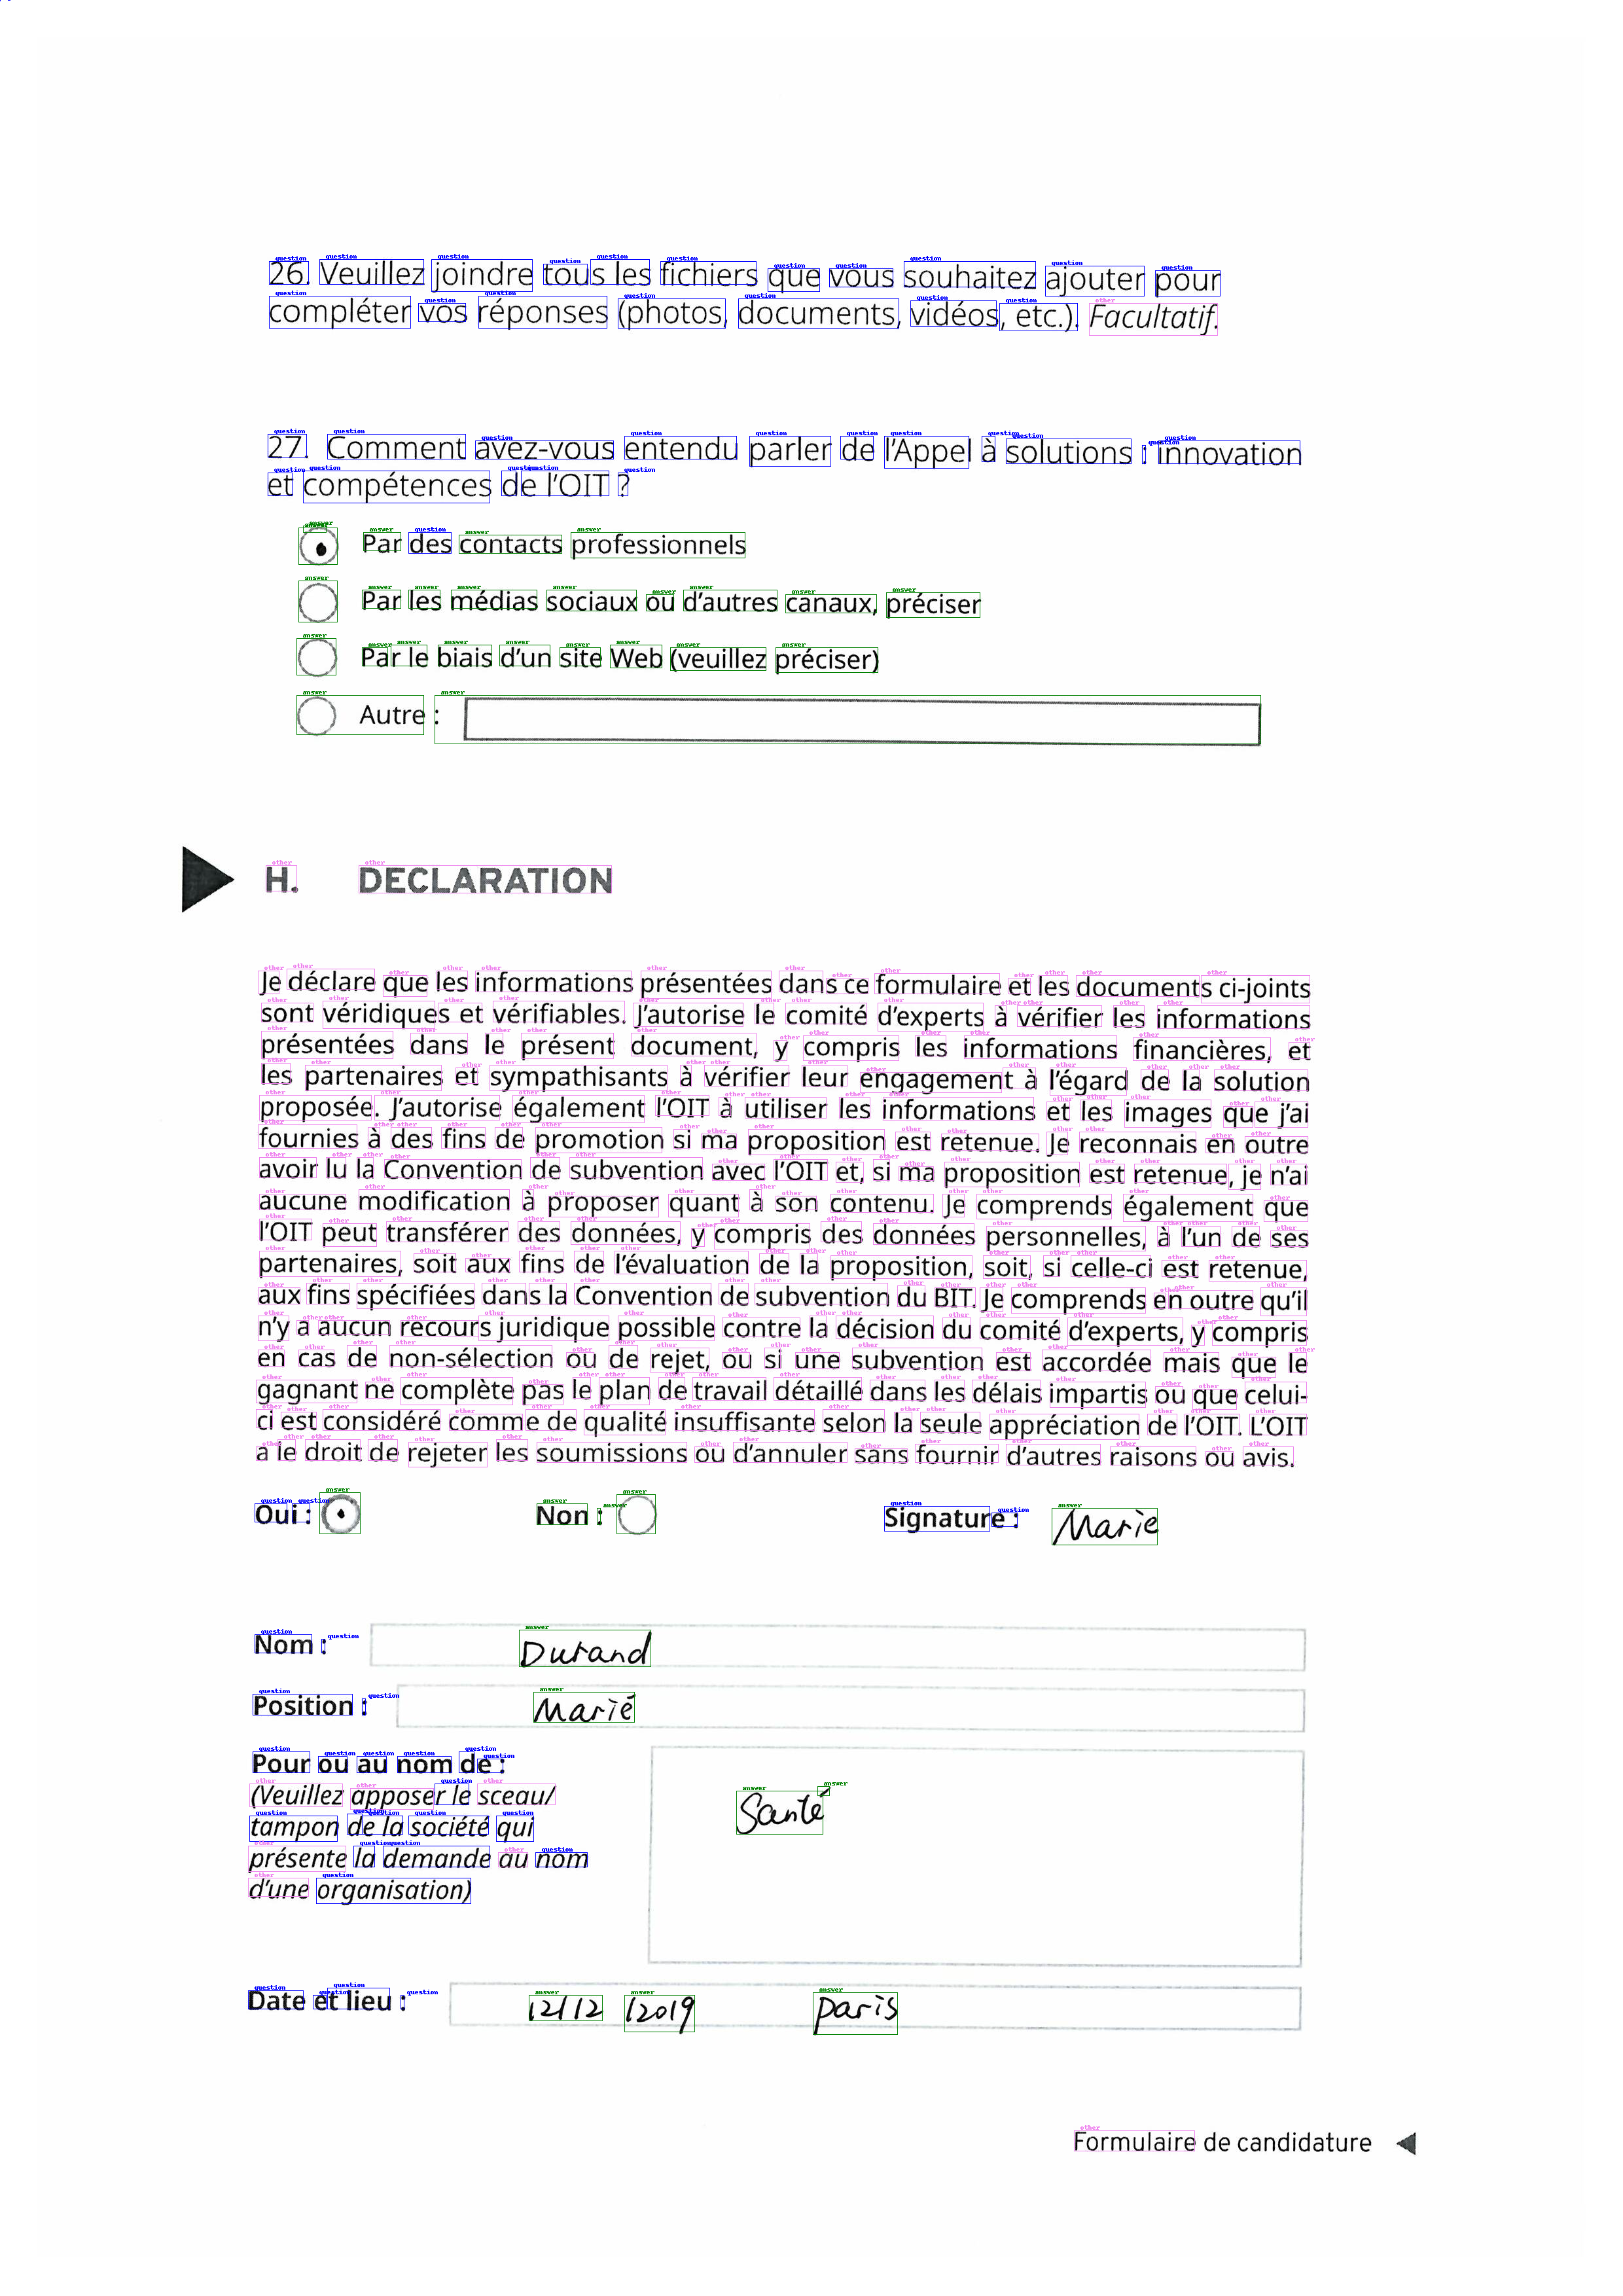

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(test_image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

test_image

Compare to the ground truth:

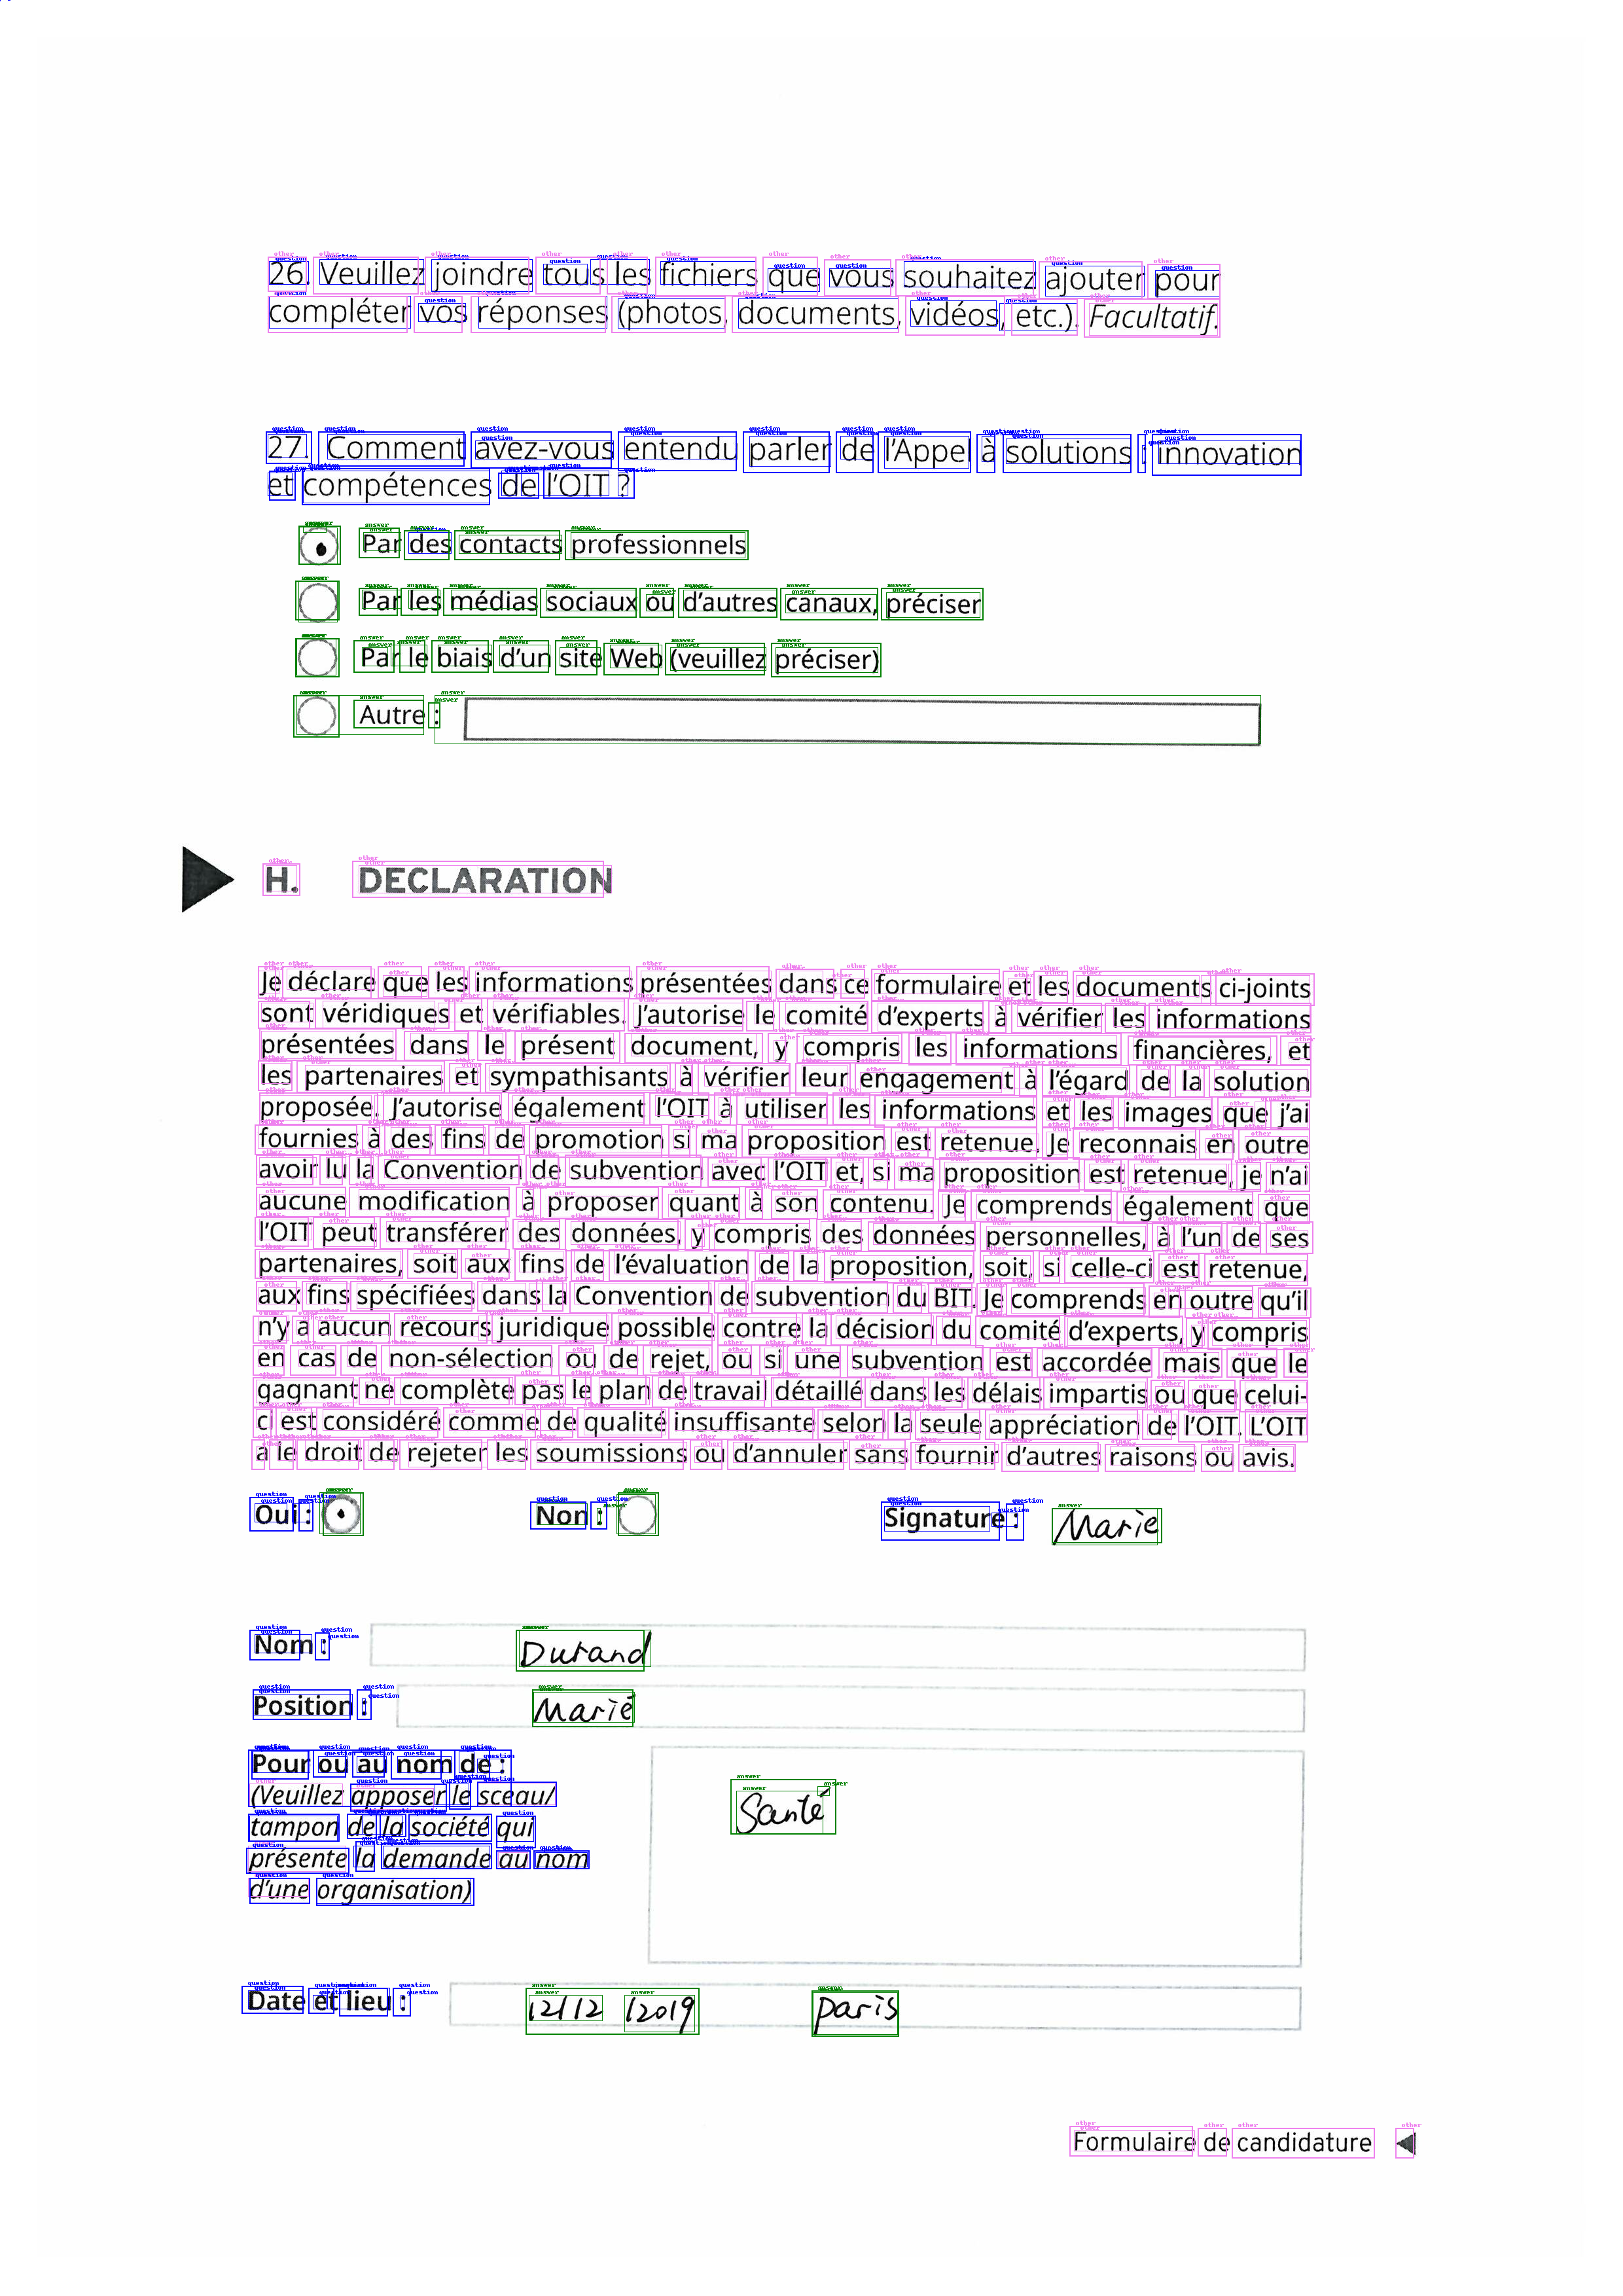

In [ ]:
# take the original image
image = example['original_image']
width, height = image.size

draw = ImageDraw.Draw(image)

for box, label in zip(example['bbox'], example['labels']):
  box = unnormalize_box(box, width, height)
  actual_label = model.config.id2label[label]
  if actual_label == 'O':
    actual_label = "other"
  elif "question" in actual_label.lower():
    actual_label = "question"
  elif "header" in actual_label.lower():
    actual_label = "header"
  elif "answer" in actual_label.lower():
    actual_label = "answer"
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Push processor to the hub

As we've used a "French" LayoutLMv2FeatureExtractor, we can wrap this up as a new LayoutXLMProcessor, which combines this "French" LayoutLMv2FeatureExtractor with the tokenizer.

We can push this processor to the hub and re-use it later using from_pretrained (rather than using the feature extractor and tokenizer separately as we did above).

In [ ]:
from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor(feature_extractor, tokenizer)

In [ ]:
processor.push_to_hub("nielsr/layoutxlm-finetuned-xfund-fr")